In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('dark')
sns.set_palette('Set2')
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

In [2]:
train_data = pd.read_csv('../input/train.csv')
test_data = pd.read_csv('../input/test.csv')
data = pd.concat([train_data, test_data]).reset_index().drop(['index'], axis=1)

str_cols = data.select_dtypes(include=["object"]).columns
data[str_cols] = (data[str_cols]
                .apply(lambda s: s.str.strip())
                .replace(r"^\s*$", np.nan, regex=True))

# Kaggle互換の Survived が欲しい場合（Perished があるときだけ）
if "Perished" in data and "Survived" not in data:
    data["Survived"] = 1 - data["Perished"]

In [3]:
data['Surname'] = data['Name'].apply(lambda x: x.split(',')[0])

In [4]:
# New Ticket_id column
data['Ticket_id'] = 'new_col'
# Initialize Ticket_id = Pclass + Ticket + Fare + Embarked
def ticket_id(row):
    row['Ticket_id'] = str(row.Pclass) + '-' + str(row.Ticket)[:-1] + '-' + str(row.Fare) + '-' + str(row.Embarked)
    return row

data = data.apply(ticket_id, axis='columns')
# New Group_id column
data['Group_id'] = 'new_col2'
# Initialize Group_id = Surname + Ticket_id
def group_id(row):
    row['Group_id'] = str(row.Surname) + '-' + str(row.Ticket_id)
    return row

data = data.apply(group_id, axis='columns')

In [5]:
# creation of the Title feature
data['Title'] = 'man'
data.loc[data.Sex == 'female', 'Title'] = 'woman'
data.loc[data['Name'].str.contains('Master'), 'Title'] = 'boy'

In [6]:
data.loc[data.Title == 'man', 'Group_id'] = 'noGroup'
# New column with WC frequency
data['WC_count'] = data.loc[data.Title != 'man'].groupby('Group_id')['Group_id'].transform('count')
# assign noGroup to every unique value
data.loc[data.WC_count <=1, 'Group_id'] = 'noGroup'

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)


In [7]:
indices = []
count = 0
for i in range(0,1309):
    if (data.loc[i,'Title'] != 'man') & (data.loc[i,'Group_id'] == 'noGroup'):
        data.loc[i,'Group_id'] = data.loc[(data['Ticket_id'] == data.loc[i, 'Ticket_id']) & (data.Title != 'man'), 'Group_id'].iloc[0]
        if (data.loc[i, 'Group_id'] != 'noGroup'):
            indices.append(i)
            count += 1
print('{:d} passengers were added to an existing group'.format(count))

11 passengers were added to an existing group


In [8]:
data['WCSurvived'] = data.loc[(data.Title != 'man') & (data.Group_id != 'noGroup')].groupby('Group_id').Survived.transform('mean')

In [9]:
# Get the family names using set difference
test_groups = set(data[891:1309].Group_id.unique()) - set(data[0:891].Group_id.unique())

In [10]:
# Assign WCSurvived = 0 to 3rd class test families, else 1
data.loc[data.Group_id.isin(test_groups), 'WCSurvived'] = 0
data.loc[(data.Group_id.isin(test_groups)) & (data.Pclass != 3), 'WCSurvived'] = 1

In [11]:
# Set everyone to 0
data.loc[891:1308, 'Predict'] = 0
# Set women to 1
data.loc[(data.index >= 891) & (data.index <= 1308) & (data.Sex == 'female'), 'Predict'] = 1
# Change WCG women with WCSurvived=0 to 0
data.loc[(data.index >= 891) & (data.index <= 1308) & (data.Sex == 'female') & (data['WCSurvived'] == 0), 'Predict'] = 0
# Change WCG boys with WCSurvived=1 to 1
data.loc[(data.index >= 891) & (data.index <= 1308) & (data.Title == 'boy') & (data['WCSurvived'] == 1), 'Predict'] = 1

In [12]:
# Calculate Ticket frequency and divide Fare by it
data['Ticket_freq'] = data.groupby('Ticket')['Ticket'].transform('count')
data['Pfare'] = data['Fare'] / data['Ticket_freq']

## NEW: Pclass × Sex 組み合わせ特徴量の作成

In [13]:
# Pclass と Sex を組み合わせた特徴量
data['Pclass_Sex'] = data['Pclass'].astype(str) + '_' + data['Sex']

print('Pclass_Sex の種類:')
print(data['Pclass_Sex'].value_counts())

# 訓練データでの生存率を確認
print('\n訓練データでの Pclass_Sex ごとの生存率:')
survival_by_pclass_sex = data[0:891].groupby('Pclass_Sex')['Survived'].mean().sort_values(ascending=False)
print(survival_by_pclass_sex)

Pclass_Sex の種類:
Pclass_Sex
3_male      493
3_female    216
1_male      179
2_male      171
1_female    144
2_female    106
Name: count, dtype: int64

訓練データでの Pclass_Sex ごとの生存率:
Pclass_Sex
1_female    0.968085
2_female    0.921053
3_female    0.500000
1_male      0.368852
2_male      0.157407
3_male      0.135447
Name: Survived, dtype: float64


In [14]:
# Isolating adult males in train and test set
train_male = data[0:891].loc[(data.Sex=='male') & (data.WCSurvived.isnull())]
test_male = data[891:1309].loc[(data.Sex=='male') & (data.WCSurvived.isnull())]

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3544: UserWarning: 16.8% of the points cannot be placed; you may want to decrease the size of the mar

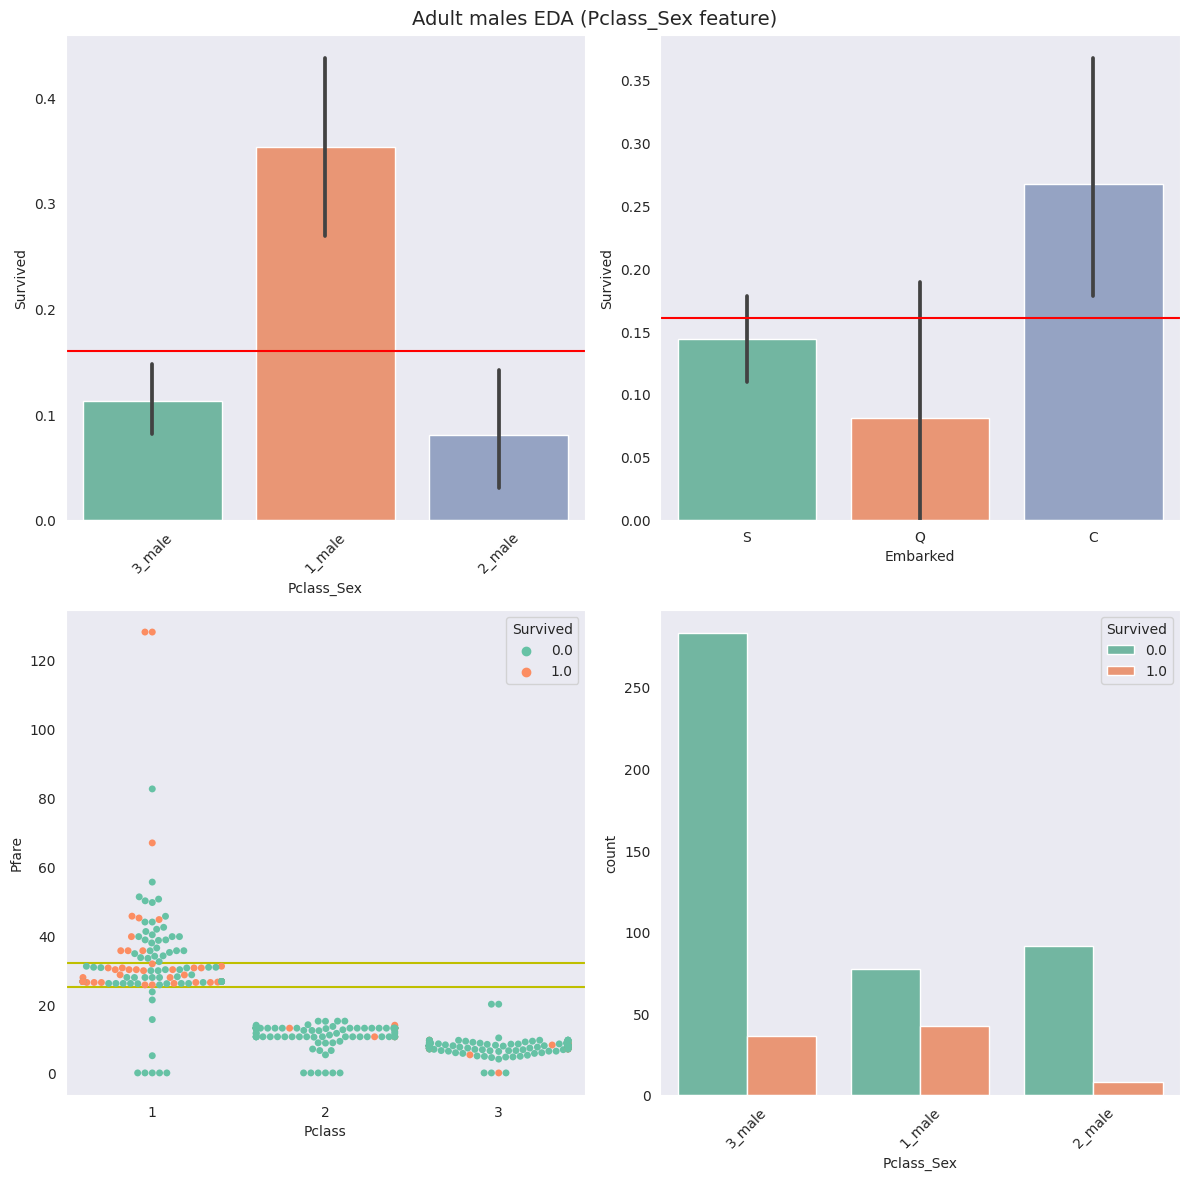

In [15]:
fig, ax = plt.subplots(2,2,figsize=(12,12))
fig.suptitle('Adult males EDA (Pclass_Sex feature)', fontsize=14)
sns.barplot(x='Pclass_Sex', y='Survived', data=train_male, ax=ax[0][0])
ax[0][0].axhline(y=train_male.Survived.mean(), color='r')
ax[0][0].tick_params(axis='x', rotation=45)
sns.barplot(x='Embarked', y='Survived', data=train_male, ax=ax[0][1])
ax[0][1].axhline(y=train_male.Survived.mean(), color='r')
sns.swarmplot(x='Pclass', y='Pfare', hue='Survived', data=train_male, ax=ax[1][0])
ax[1][0].axhline(y=25, color='y')
ax[1][0].axhline(y=32, color='y')
sns.countplot(x='Pclass_Sex', hue='Survived', data=train_male, ax=ax[1][1])
ax[1][1].tick_params(axis='x', rotation=45)
plt.tight_layout()

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

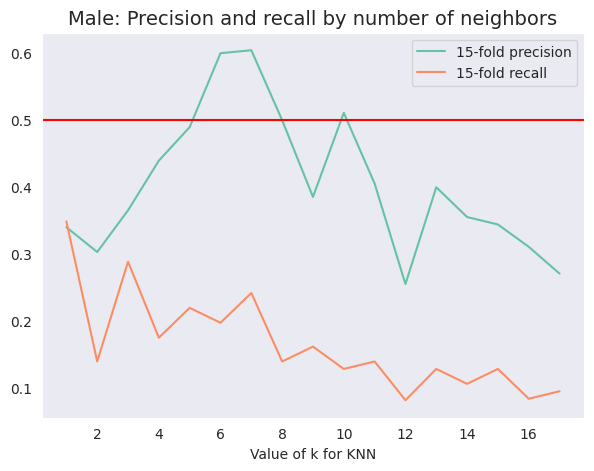

In [16]:
# 特徴量の設定: Age を除外し、Pclass_Sex を追加
cols = ['PassengerId', 'Name', 'Pfare', 'Pclass_Sex', 'Embarked', 'Survived']
y_m = train_male['Survived']
features = ['Pfare', 'Pclass_Sex', 'Embarked']  # Age除外、Pclass_Sex追加
X_m = train_male[features]

numerical_cols = ['Pfare']  # Age除外
categorical_cols = ['Pclass_Sex', 'Embarked']  # Pclass_Sex追加

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

precision_m = []
recall_m = []

for k in range(1,18):
    pipeline1 = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', KNeighborsClassifier(n_neighbors=k))
    ])
    precision_m.append(cross_val_score(pipeline1, X_m, y_m, cv=15, n_jobs=-1, scoring='precision').mean())
    recall_m.append(cross_val_score(pipeline1, X_m, y_m, cv=15, n_jobs=-1, scoring='recall').mean())
    
k_range = range(1,18)
plt.figure(figsize=(7,5))
plt.plot(k_range, precision_m, label='15-fold precision')
plt.plot(k_range, recall_m, label='15-fold recall')
plt.axhline(y=0.5, color='r')
plt.xlabel('Value of k for KNN')
plt.title('Male: Precision and recall by number of neighbors', fontsize=14)
plt.legend()
plt.show()

In [17]:
m1 = KNeighborsClassifier(n_neighbors=1)
m2 = KNeighborsClassifier(n_neighbors=3)
m3 = KNeighborsClassifier(n_neighbors=7)
# Preprocessing is the same as before
male_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('voting',VotingClassifier([
        ('m1', m1), ('m2', m2), ('m3', m3)]))
])
print('15-fold precision of the ensemble: {:.3f}'.format(
    cross_val_score(male_pipeline, X_m, y_m, cv=15, n_jobs=-1, scoring='precision').mean()))
print('15-fold recall of the ensemble: {:.3f}'.format(
    cross_val_score(male_pipeline, X_m, y_m, cv=15, n_jobs=-1, scoring='recall').mean()))
print('15-fold accuracy of the ensemble: {:.3f}'.format(
    cross_val_score(male_pipeline, X_m, y_m, cv=15, n_jobs=-1).mean()))
# Fit model and make predictions
male_pipeline.fit(X_m, y_m)
learn_train_m = male_pipeline.predict(X_m)
X_test_m = test_male[features]
predictions_m = male_pipeline.predict(X_test_m)
print('\nThe following adult males are predicted to live:')
print(test_male.loc[(predictions_m==1), cols])

15-fold precision of the ensemble: 0.404
15-fold recall of the ensemble: 0.267
15-fold accuracy of the ensemble: 0.816

The following adult males are predicted to live:
      PassengerId                             Name      Pfare Pclass_Sex  \
919           920          Brady, Mr. John Bertram  30.500000     1_male   
925           926         Mock, Mr. Philipp Edmund  28.875000     1_male   
930           931                    Hee, Mr. Ling   7.061975     3_male   
941           942         Smith, Mr. Lucien Philip  30.000000     1_male   
959           960  Tucker, Mr. Gilbert Milligan Jr  28.537500     1_male   
985           986              Birnbaum, Mr. Jakob  26.000000     1_male   
986           987       Tenglin, Mr. Gunnar Isidor   7.795800     3_male   
1017         1018         Brobeck, Mr. Karl Rudolf   7.795800     3_male   
1022         1023        Gracie, Col. Archibald IV  28.500000     1_male   
1068         1069  Stengel, Mr. Charles Emil Henry  27.720850     1_mal

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [18]:
# Update predictions for males
mask_male = (data.index >= 891) & (data.index <= 1308) & (data.Sex=='male') & (data.WCSurvived.isnull())
data.loc[mask_male, 'Predict'] = predictions_m

In [19]:
train_female = data[0:891].loc[(data.Sex=='female')  & (data.WCSurvived.isnull())]
test_female = data[891:1309].loc[(data.Sex=='female') & (data.WCSurvived.isnull())]

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3544: UserWarning: 26.5% of the points cannot be placed; you may want to decrease the size of the mar

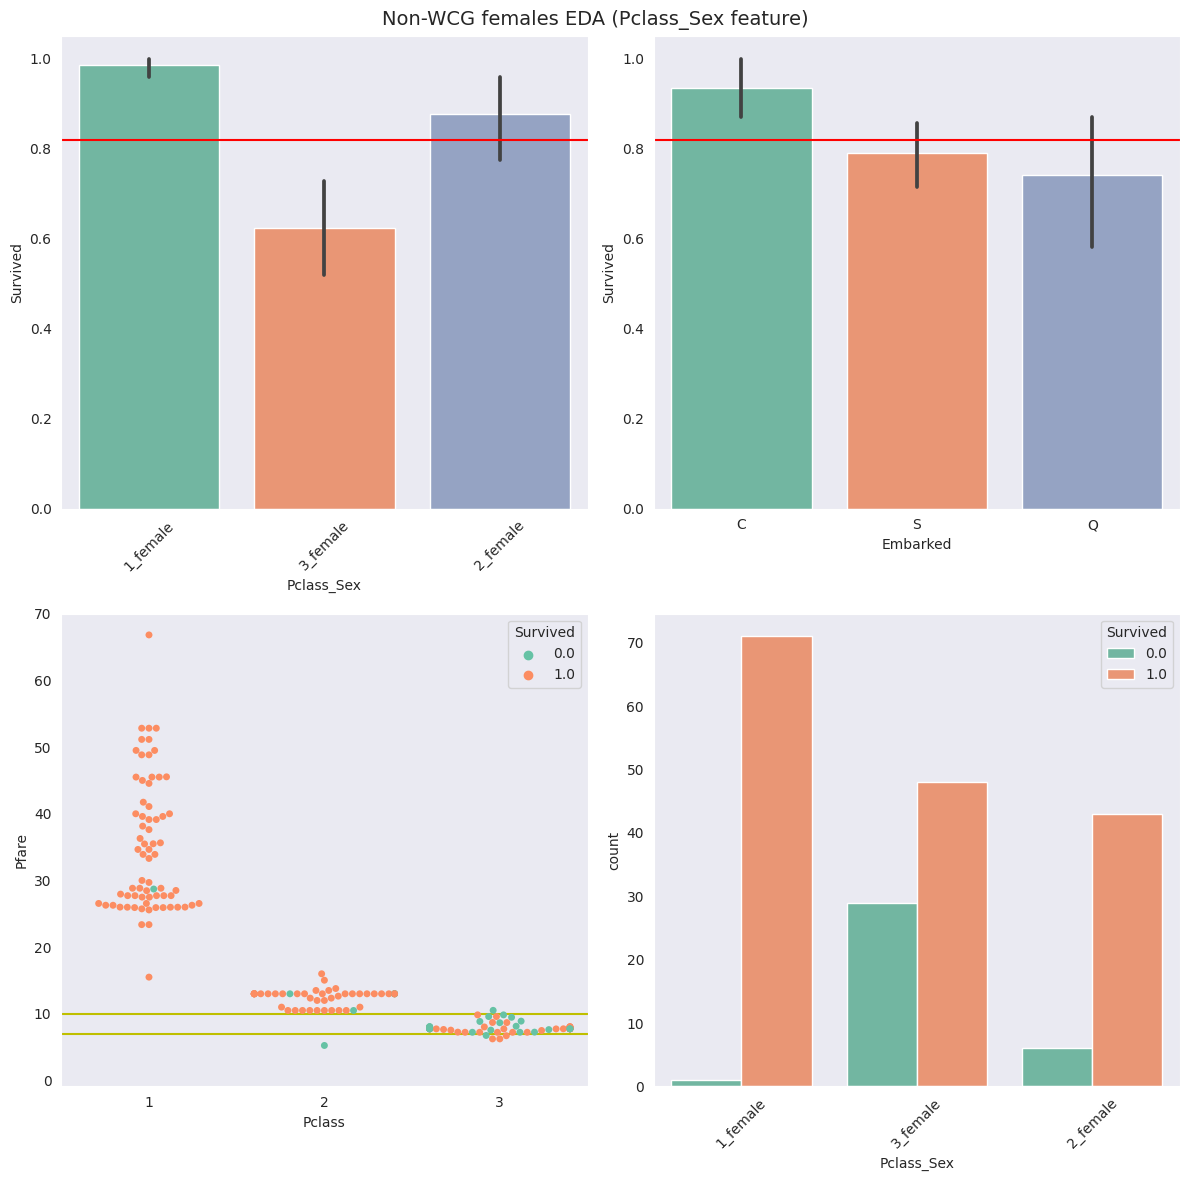

In [20]:
fig, ax = plt.subplots(2,2,figsize=(12,12))
fig.suptitle('Non-WCG females EDA (Pclass_Sex feature)', fontsize=14)
sns.barplot(x='Pclass_Sex', y='Survived', data=train_female, ax=ax[0][0])
ax[0][0].axhline(y=train_female.Survived.mean(), color='r')
ax[0][0].tick_params(axis='x', rotation=45)
sns.barplot(x='Embarked', y='Survived', data=train_female, ax=ax[0][1])
ax[0][1].axhline(y=train_female.Survived.mean(), color='r')
sns.swarmplot(x='Pclass', y='Pfare', hue='Survived', data=train_female, ax=ax[1][0])
ax[1][0].set_ylim(top=70)
ax[1][0].axhline(y=7, color='y')
ax[1][0].axhline(y=10, color='y')
sns.countplot(x='Pclass_Sex', hue='Survived', data=train_female, ax=ax[1][1])
ax[1][1].tick_params(axis='x', rotation=45)
plt.tight_layout()

In [21]:
from sklearn.metrics import make_scorer, precision_score, recall_score
# We set zero_division=0 to avoid raising errors
custom_precision = make_scorer(precision_score, pos_label=0, zero_division=0)
custom_recall = make_scorer(recall_score, pos_label=0)

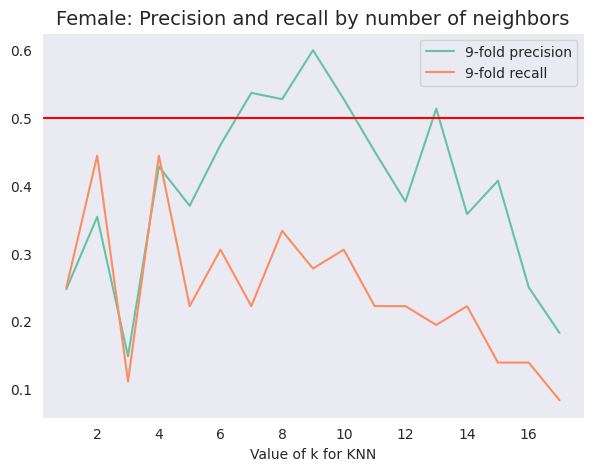

In [22]:
y_f = train_female['Survived']
X_f = train_female[features]  # Age除外、Pclass_Sex使用
precision_f = []
recall_f = []
# Preprocessing is always the same...
for k in range(1,18):
    pipeline2 = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', KNeighborsClassifier(n_neighbors=k))
    ])
    precision_f.append(cross_val_score(pipeline2, X_f, y_f, cv=9, n_jobs=-1, scoring=custom_precision).mean())
    recall_f.append(cross_val_score(pipeline2, X_f, y_f, cv=9, n_jobs=-1, scoring=custom_recall).mean())
    
plt.figure(figsize=(7,5))
plt.plot(k_range, precision_f, label='9-fold precision')
plt.plot(k_range, recall_f, label='9-fold recall')
plt.axhline(y=0.5, color='r')
plt.xlabel('Value of k for KNN')
plt.title('Female: Precision and recall by number of neighbors', fontsize=14)
plt.legend()
plt.show()

In [23]:
from sklearn.model_selection import cross_validate

f1 = KNeighborsClassifier(n_neighbors=4)
f2 = KNeighborsClassifier(n_neighbors=9)
f3 = KNeighborsClassifier(n_neighbors=11)

# Preprocessing pipelines are the same as before
female_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('voting', VotingClassifier([
        ('f1', f1), ('f2', f2), ('f3', f3)]))
])

# Cross-validation scores
cv_results = cross_validate(
    female_pipeline, X_f, y_f, cv=9,
    scoring={
        'precision': custom_precision,
        'recall': custom_recall,
        'accuracy': 'accuracy'
    },
    return_train_score=True
)

print('=' * 60)
print('VALIDATION SCORES (Cross-Validation Results)')
print('=' * 60)
print(f'CV Score - Precision (9-fold): {cv_results["test_precision"].mean():.3f} (+/- {cv_results["test_precision"].std():.3f})')
print(f'CV Score - Recall (9-fold):    {cv_results["test_recall"].mean():.3f} (+/- {cv_results["test_recall"].std():.3f})')
print(f'CV Score - Accuracy (9-fold):  {cv_results["test_accuracy"].mean():.3f} (+/- {cv_results["test_accuracy"].std():.3f})')
print()
print('Train Scores (for comparison):')
print(f'Train Precision: {cv_results["train_precision"].mean():.3f}')
print(f'Train Recall:    {cv_results["train_recall"].mean():.3f}')
print(f'Train Accuracy:  {cv_results["train_accuracy"].mean():.3f}')
print('=' * 60)

# Preprocessing of training data, fit model
female_pipeline.fit(X_f, y_f)
learn_train_f = female_pipeline.predict(X_f)
X_test_f = test_female[features]
predictions_f = female_pipeline.predict(X_test_f)

print('\nThe following non-WCG females are predicted to die:')
print(test_female.loc[(predictions_f==0), cols])

VALIDATION SCORES (Cross-Validation Results)
CV Score - Precision (9-fold): 0.583 (+/- 0.416)
CV Score - Recall (9-fold):    0.306 (+/- 0.196)
CV Score - Accuracy (9-fold):  0.813 (+/- 0.092)

Train Scores (for comparison):
Train Precision: 0.614
Train Recall:    0.299
Train Accuracy:  0.838

The following non-WCG females are predicted to die:
      PassengerId                                               Name   Pfare  \
1060         1061                       Hellstrom, Miss. Hilda Maria  8.9625   
1088         1089                        Nilsson, Miss. Berta Olivia  7.7750   
1105         1106             Andersson, Miss. Ida Augusta Margareta  7.7750   
1236         1237                        Abelseth, Miss. Karen Marie  7.6500   
1250         1251  Lindell, Mrs. Edvard Bengtsson (Elin Gerda Per...  7.7750   
1267         1268                                  Kink, Miss. Maria  8.6625   
1303         1304                     Henriksson, Miss. Jenny Lovisa  7.7750   

     Pclass_S

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [24]:
import os

# Update predictions for females
mask_female = (data.index >= 891) & (data.index <= 1308) & (data.Sex=='female') & (data.WCSurvived.isnull())
data.loc[mask_female, 'Predict'] = predictions_f

# Survived形式(Predict) → Perished形式に変換
output = pd.DataFrame({
    'PassengerId': data[891:1309].PassengerId, 
    'Perished': (1 - data[891:1309].Predict).astype('int')
})

# outputフォルダがなければ作成
os.makedirs('../output', exist_ok=True)

output.to_csv('../output/knn_pclass_sex.csv', index=False)
print('knn_pclass_sex.csv was successfully saved to output folder!')
print('\nFeatures used: Pfare, Pclass_Sex (Pclass × Sex combination), Embarked')
print('Age was excluded from this model.')

knn_pclass_sex.csv was successfully saved to output folder!

Features used: Pfare, Pclass_Sex (Pclass × Sex combination), Embarked
Age was excluded from this model.


In [25]:
# 予測結果のサマリー
print('\n=== Prediction Summary ===')
print(f'Total predictions: {len(output)}')
print(f'Predicted to die (Perished=1): {(output["Perished"] == 1).sum()}')
print(f'Predicted to survive (Perished=0): {(output["Perished"] == 0).sum()}')
print(f'\nSurvival rate: {(output["Perished"] == 0).sum() / len(output) * 100:.1f}%')


=== Prediction Summary ===
Total predictions: 418
Predicted to die (Perished=1): 267
Predicted to survive (Perished=0): 151

Survival rate: 36.1%
